In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels


def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_training.p')


def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])


In [2]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 5:
Image - Min Value: 9 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


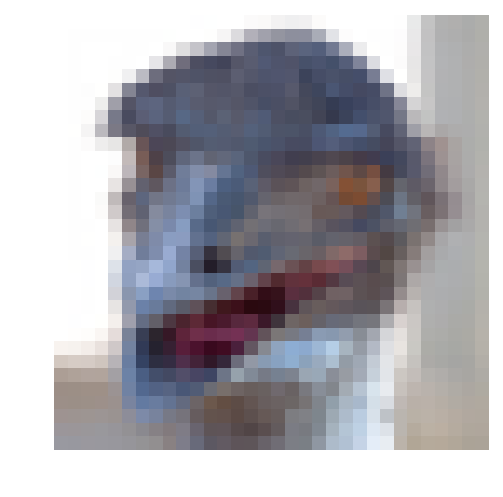

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 5
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [4]:
import numpy as np
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = np.array(x)
    x_max = np.max(x)
    x_min = np.min(x)
    output = (x - x_min)/(x_max - x_min)
    return output


In [5]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(range(10))
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    
    return lb.transform(x)


In [6]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [7]:
all_images = []
all_labels = []
for batch_id in range(1, 6):
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))
    
    all_images.extend(features)
    all_labels.extend(labels)

In [8]:
filename = 'preprocess_validation.p'
valid_features, valid_labels = pickle.load(open(filename, mode='rb'))

In [9]:
all_images = np.array(all_images)
all_labels = np.array(all_labels)

In [10]:
print(all_images.shape)
print(all_labels.shape)

(45000, 32, 32, 3)
(45000, 10)


## Keras CNN Model

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


In [12]:
model = Sequential()
model.add(Conv2D(64, (4, 4), padding="same",input_shape=all_images.shape[1:], activation='relu', data_format='channels_last'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [13]:
model = Sequential()
model.add(Conv2D(64, (4, 4), padding="same",input_shape=all_images.shape[1:], activation='relu', data_format='channels_last'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [14]:
model = Sequential()
model.add(Conv2D(64, (4, 4), padding="same",input_shape=all_images.shape[1:], activation='relu', data_format='channels_last'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(10, activation='softmax'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 256)       147712    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)             0         
__________

In [16]:
model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])

In [17]:
model.fit(all_images, all_labels, epochs=10, batch_size=56)

Epoch 1/10
45000/45000 [==============================] - 825s 18ms/step - loss: 1.6178 - acc: 0.4092
Epoch 2/10
45000/45000 [==============================] - 909s 20ms/step - loss: 1.2345 - acc: 0.5621
Epoch 3/10
45000/45000 [==============================] - 895s 20ms/step - loss: 1.0838 - acc: 0.6182
Epoch 4/10
45000/45000 [==============================] - 973s 22ms/step - loss: 0.9828 - acc: 0.6554
Epoch 5/10
45000/45000 [==============================] - 1027s 23ms/step - loss: 0.9003 - acc: 0.6837
Epoch 6/10
45000/45000 [==============================] - 989s 22ms/step - loss: 0.8454 - acc: 0.7030
Epoch 7/10
45000/45000 [==============================] - 1003s 22ms/step - loss: 0.7878 - acc: 0.7226
Epoch 8/10
45000/45000 [==============================] - 883s 20ms/step - loss: 0.7322 - acc: 0.7420
Epoch 9/10
45000/45000 [==============================] - 958s 21ms/step - loss: 0.7011 - acc: 0.7517
Epoch 10/10
45000/45000 [==============================] - 941s 21ms/step - loss

In [18]:
model.evaluate(valid_features, valid_labels)

5000/5000 [==============================] - 20s 4ms/step


[0.7764536685943604, 0.7326]

In [19]:
valid_pred = model.predict(valid_features)

In [20]:
confusion_matrix(valid_labels.argmax(axis=1), valid_pred.argmax(axis=1))

array([[354,   4,  14,   6,  19,   3,   8,   2,  58,  21],
       [  9, 454,   0,   3,   3,   0,  10,   1,  17,  37],
       [ 27,   2, 262,  25,  85,  11,  50,  10,  11,   2],
       [ 16,   2,  24, 266,  52,  60,  58,  16,  10,   6],
       [  6,   0,   6,  15, 378,   7,  26,  27,   7,   1],
       [  7,   1,  21, 103,  38, 228,  35,  34,   2,   2],
       [  0,   5,  13,  17,  27,   2, 431,   2,   0,   2],
       [  5,   0,   8,  19,  46,  20,   2, 394,   1,   4],
       [ 15,  11,   1,   5,   7,   0,   7,   2, 471,   6],
       [  9,  31,   1,   9,   7,   2,   6,   6,  19, 425]], dtype=int64)

## CNN Pre-Trained Models

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import tensorflow as tf
from IPython.display import display
from PIL import Image

Using TensorFlow backend.


In [3]:
sess = tf.Session()

In [4]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [5]:
from PIL import Image
print(Image.__file__)

C:\Anaconda3\envs\tensorflows\lib\site-packages\PIL\Image.py


In [6]:
import Image
print(Image.__file__)

C:\Anaconda3\envs\tensorflows\lib\site-packages\PIL\Image.py


In [11]:
model = ResNet50(weights='imagenet')

img_path = 'tiger.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
    
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)

In [12]:
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 6us/step
Predicted: [('n02129604', 'tiger', 0.82760346), ('n02123159', 'tiger_cat', 0.16761719), ('n02127052', 'lynx', 0.002437188)]
